In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from datetime import datetime

import seaborn as sns

%matplotlib inline

print(tf.__version__)

2.9.1


In [2]:
# load training
train_df = pd.read_csv("./../data/PM_train.txt", sep=" ", header=None)

train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [3]:
train_df = train_df.sort_values(['id','cycle'])

In [4]:
# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('./../data/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [5]:
# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('./../data/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

# Data Preprocessing

     # 1. TRAIN

In [6]:
# generate column RUL(Remaining Usefull Life or Time to Failure)
helpcols = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
helpcols.columns = ['id', 'max']
train_df = train_df.merge(helpcols, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

In [7]:
# generate label columns for training data
# only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

In [8]:
# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)


    # 2. TEST

In [9]:
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [10]:
# use the ground truth dataset to generate labels for the test data.
# generate column max for test data
helpcols = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
helpcols.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = helpcols['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [11]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

In [12]:
# pick a large window size of 50 cycles
sequence_length = 50

In [13]:
# reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [14]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [15]:
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
len(val)

142

In [16]:
# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [17]:
# concatenate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [18]:
# generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

In [19]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [20]:
# TEST DATA

# We pick the last sequence for each id in the test data
seq_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_test_last = np.asarray(seq_test_last).astype(np.float32)
print("seq_test_last")
print(seq_test_last.shape)

# Similarly, we pick the labels
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_test_last = label_test_last.reshape(label_test_last.shape[0],1).astype(np.float32)
print(label_test_last.shape)
print("label_test_last")
print(label_test_last)

seq_test_last
(93, 50, 25)
(93, 1)
label_test_last
[[ 69.]
 [ 82.]
 [ 91.]
 [ 93.]
 [ 91.]
 [ 95.]
 [111.]
 [ 96.]
 [ 97.]
 [124.]
 [ 95.]
 [ 83.]
 [ 84.]
 [ 50.]
 [ 28.]
 [ 87.]
 [ 16.]
 [ 57.]
 [113.]
 [ 20.]
 [119.]
 [ 66.]
 [ 97.]
 [ 90.]
 [115.]
 [  8.]
 [ 48.]
 [106.]
 [  7.]
 [ 11.]
 [ 19.]
 [ 21.]
 [ 50.]
 [ 28.]
 [ 18.]
 [ 10.]
 [ 59.]
 [109.]
 [114.]
 [ 47.]
 [135.]
 [ 92.]
 [ 21.]
 [ 79.]
 [114.]
 [ 29.]
 [ 26.]
 [ 97.]
 [137.]
 [ 15.]
 [103.]
 [ 37.]
 [114.]
 [100.]
 [ 21.]
 [ 54.]
 [ 72.]
 [ 28.]
 [128.]
 [ 14.]
 [ 77.]
 [  8.]
 [121.]
 [ 94.]
 [118.]
 [ 50.]
 [131.]
 [126.]
 [113.]
 [ 10.]
 [ 34.]
 [107.]
 [ 63.]
 [ 90.]
 [  8.]
 [  9.]
 [137.]
 [ 58.]
 [ 89.]
 [116.]
 [115.]
 [136.]
 [ 28.]
 [ 38.]
 [ 20.]
 [ 85.]
 [ 55.]
 [128.]
 [137.]
 [ 82.]
 [ 59.]
 [117.]
 [ 20.]]


# Modeling

In [21]:
import tensorflow.keras.backend as K

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# LSTM Network
# the network has a following layers:
# 1. an LSTM layer with 100 units
# 2. dropout after each LSTM layer to control overfitting
# 3. an LSTM layer with 50 units
# 4. dropout after each LSTM layer to control overfitting
# 5. a dense output layer with single unit and linear activation since this is a regression problem

In [22]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='linear'))

model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.RMSprop(), 
              metrics=[tf.metrics.MeanAbsoluteError(), r2_keras])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Paths

PATH_DATA = "./"
PATH_MODELS = PATH_DATA + "models/"
PATH_CHECKPOINTS = PATH_MODELS + "checkpoints/"
PATH_MODEL = PATH_CHECKPOINTS + "aircraft_regression_model.h5"

# stop training when validation acc starts dropping
# save checkpoint of model each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# create callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", min_delta=0, verbose=1, patience=10, mode='min'),
    ModelCheckpoint(
        ##PATH_CHECKPOINTS + now + "_Model_{epoch:02d}_{val_loss:.4f}.h5",
        PATH_MODEL,
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
        mode='min'
    ),
]

In [25]:
# fit the network
%time
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2, shuffle=True,
          callbacks = callbacks
          )

Wall time: 0 ns
Epoch 1/100

Epoch 1: val_loss improved from inf to 8265.87305, saving model to ./models/checkpoints\aircraft_regression_model.h5
75/75 - 8s - loss: 8837.5078 - mean_absolute_error: 75.2782 - r2_keras: -1.7197e+00 - val_loss: 8265.8730 - val_mean_absolute_error: 72.5005 - val_r2_keras: -2.4785e+00 - 8s/epoch - 113ms/step
Epoch 2/100

Epoch 2: val_loss improved from 8265.87305 to 7735.11816, saving model to ./models/checkpoints\aircraft_regression_model.h5
75/75 - 2s - loss: 8172.2646 - mean_absolute_error: 71.4333 - r2_keras: -1.5173e+00 - val_loss: 7735.1182 - val_mean_absolute_error: 69.4155 - val_r2_keras: -2.2276e+00 - 2s/epoch - 22ms/step
Epoch 3/100

Epoch 3: val_loss improved from 7735.11816 to 7238.50488, saving model to ./models/checkpoints\aircraft_regression_model.h5
75/75 - 2s - loss: 7657.5254 - mean_absolute_error: 68.4794 - r2_keras: -1.3564e+00 - val_loss: 7238.5049 - val_mean_absolute_error: 66.5451 - val_r2_keras: -1.9948e+00 - 2s/epoch - 21ms/step
Epo

Epoch 26/100

Epoch 26: val_loss improved from 3084.91602 to 2287.52856, saving model to ./models/checkpoints\aircraft_regression_model.h5
75/75 - 2s - loss: 2813.1433 - mean_absolute_error: 39.9144 - r2_keras: 0.1435 - val_loss: 2287.5286 - val_mean_absolute_error: 34.3052 - val_r2_keras: 0.2040 - 2s/epoch - 21ms/step
Epoch 27/100

Epoch 27: val_loss improved from 2287.52856 to 1874.80994, saving model to ./models/checkpoints\aircraft_regression_model.h5
75/75 - 2s - loss: 2081.6846 - mean_absolute_error: 31.2920 - r2_keras: 0.3649 - val_loss: 1874.8099 - val_mean_absolute_error: 30.3199 - val_r2_keras: 0.2592 - 2s/epoch - 21ms/step
Epoch 28/100

Epoch 28: val_loss improved from 1874.80994 to 1644.87585, saving model to ./models/checkpoints\aircraft_regression_model.h5
75/75 - 2s - loss: 1842.2131 - mean_absolute_error: 28.3542 - r2_keras: 0.4342 - val_loss: 1644.8759 - val_mean_absolute_error: 27.2791 - val_r2_keras: 0.3817 - 2s/epoch - 21ms/step
Epoch 29/100

Epoch 29: val_loss impr

In [26]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'r2_keras', 'val_loss', 'val_mean_absolute_error', 'val_r2_keras'])

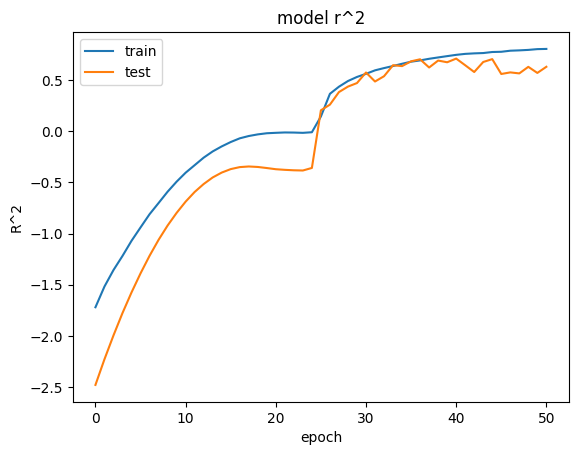

In [27]:
# summarize history for R^2
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

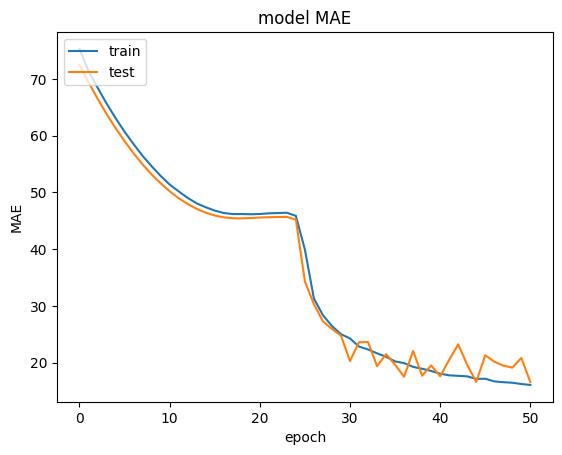

In [28]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

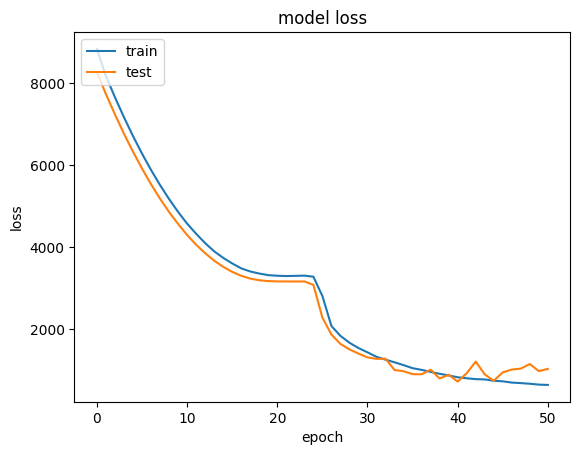

In [29]:
# summarize history for Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

79/79 [==============================] - 2s 19ms/step - loss: 586.7179 - mean_absolute_error: 13.9045 - r2_keras: 0.8177

MAE: 13.904457092285156

R^2: 0.8177416920661926


In [31]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array



79/79 [==============================] - 2s 14ms/step


In [32]:
# test metrics
model = load_model(PATH_MODEL, custom_objects={'r2_keras': r2_keras})
scores_test = model.evaluate(seq_test_last, label_test_last, verbose=2)
print('\nMAE: {}'.format(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))

3/3 - 1s - loss: 276.7399 - mean_absolute_error: 11.8222 - r2_keras: 0.8310 - 926ms/epoch - 309ms/step

MAE: 11.822196006774902

R^2: 0.8309925198554993


In [33]:
y_pred_test = model.predict(seq_test_last)
y_true_test = label_test_last

3/3 [==============================] - 1s 53ms/step


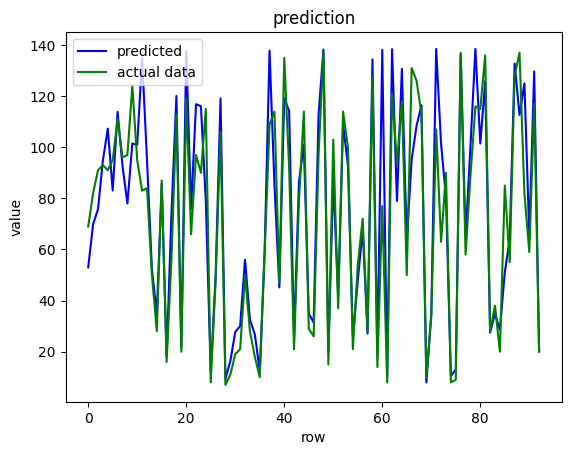

In [34]:
# plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.

plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()